In [1]:
"""
准备数据集：将临床医学的图片整理为不同的类别并将其划分为训练集和测试集。

加载数据集：使用Python中的图像处理库如OpenCV或Pillow加载图片，并将其转换为合适的数据格式，如numpy数组。

定义模型：使用TensorFlow或PyTorch定义深度学习模型，通常是卷积神经网络（CNN）。

训练模型：使用训练集对模型进行训练，并调整模型参数以获得更好的性能。

评估模型：使用测试集对模型进行评估，并计算其准确度、精确度和召回率等指标。

预测：使用训练好的模型对新的临床医学图片进行分类。
"""
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns

In [2]:
# 设置数据集目录和图像大小
train_dir_Normal = 'chest X-ray_images/chest_xray/train/NORMAL'
train_dir_Pneumonia = 'chest X-ray_images/chest_xray/train/PNEUMONIA/'
train_dir = 'chest X-ray_images/chest_xray/train'

test_dir_Normal = 'chest X-ray_images/chest_xray/test/NORMAL'
test_dir_Pneumonia = 'chest X-ray_images/chest_xray/test/PNEUMONIA'
test_dir = 'chest X-ray_images/chest_xray/test'

test_dir_val_Normal = 'chest X-ray_images/chest_xray/val/NORMAL'
test_dir_val_Pneumonia = 'chest X-ray_images/chest_xray/val/PNEUMONIA'
test_dir_val = 'chest X-ray_images/chest_xray/val'

img_size = (224, 224)
labels = ['NORMAL', 'PNEUMONIA']

#打印数据集中的图片数量
print('total training images:', len(os.listdir(train_dir_Normal)) + len(os.listdir(train_dir_Pneumonia)))
print('Positive training images:', len(os.listdir(train_dir_Pneumonia)))
print('Negative training images:', len(os.listdir(train_dir_Normal)))
print('total test images:', len(os.listdir(test_dir_Normal)) + len(os.listdir(test_dir_Pneumonia)))
print('Positive test images:', len(os.listdir(test_dir_Pneumonia)))
print('Negative test images:', len(os.listdir(test_dir_Normal)))
print('total val images:', len(os.listdir(test_dir_val_Normal)) + len(os.listdir(test_dir_val_Pneumonia)))
print('Positive val images:', len(os.listdir(test_dir_val_Pneumonia)))
print('Negative val images:', len(os.listdir(test_dir_val_Normal)))


total training images: 5216
Positive training images: 3875
Negative training images: 1341
total test images: 624
Positive test images: 390
Negative test images: 234
total val images: 16
Positive val images: 8
Negative val images: 8


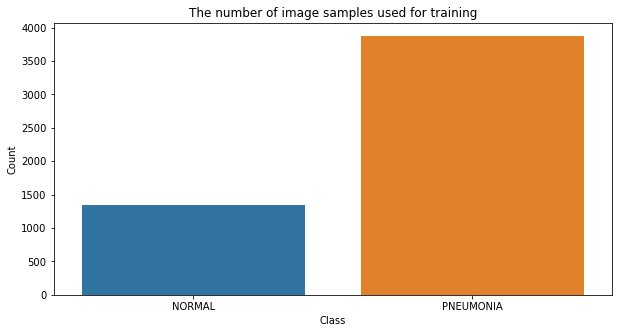

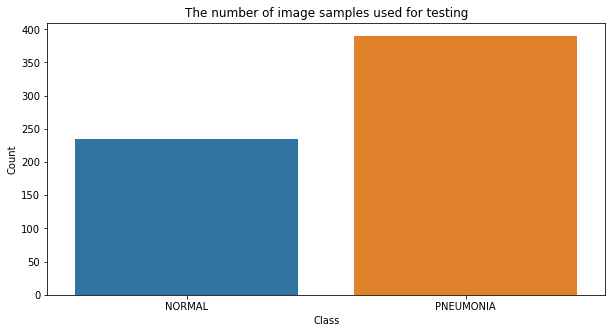

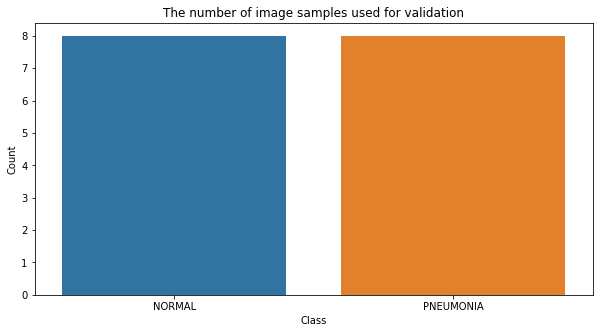

In [3]:
#Data Processing and Visualization
#将train_dir, test_dir, test_dir_val转换成柱状图
def get_data_to_bar(data_dir):
    count = []
    for img in labels:
        path = os.path.join(data_dir, img)
        count.append(len(os.listdir(path)))
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=count)
    plt.xlabel('Class')
    plt.ylabel('Count')
    #根据文件夹名，打印出对应的train/test/val标题
    if data_dir == train_dir:
        plt.title('The number of image samples used for training')
    elif data_dir == test_dir:
        plt.title('The number of image samples used for testing')
    else:
        plt.title('The number of image samples used for validation')
    plt.show()


get_data_to_bar(train_dir)
get_data_to_bar(test_dir)
get_data_to_bar(test_dir_val)

由于数据集中的图片数量不均衡，因此需要对其进行平衡

为了使数据集中的图片数量均衡，我们将使用数据增强技术(Data Augmentation technique)来增加数据集中的图片数量

Q: 为什么要对数据集进行平衡？ Ans:https://zhuanlan.zhihu.com/p/41679153

在下文对图像的处理环节中使用


In [4]:
#将train_dir_Normal和train_dir_Pneumonia的图片定义标签后随机排列在一起，并将其转换为numpy数组
img_size = 224
labels = ['NORMAL', 'PNEUMONIA']
def get_data(data_dir):
    data = []
    for label in os.listdir(data_dir):
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE表示将图片转换为灰度图
                resized_arr = cv2.resize(img_arr, (img_size,img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train_data = get_data(train_dir)
test_data = get_data(test_dir)
val_data = get_data(test_dir_val)
#print(train_data.shape)
#将train_data和train_labels打印出来
#train_data.shape = (5216, 224, 224, 3)  train_labels.shape = (5216,)  照片总数为5216张，每张照片的大小为224*224*3, 3表示RGB三个通道

<Figure size 432x288 with 0 Axes>

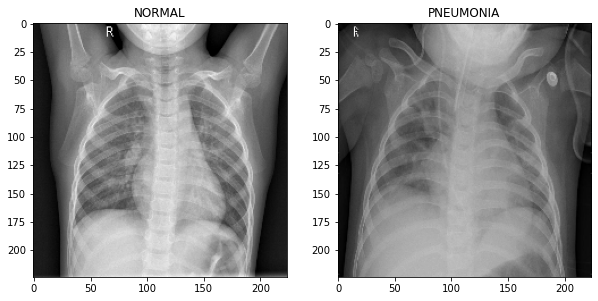

In [27]:
#打印一张NORMAL和PNEUMONIA的图片

plt.figure()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_data[0][0], cmap='gray')
plt.title('NORMAL')
plt.subplot(1, 2, 2)

plt.imshow(train_data[5215][0], cmap='gray')
plt.title('PNEUMONIA')
plt.show()

#preview_data(train_data, train_labels)
#print('ok')

对于图像的处理分析研究：

方法一：使用Keras的ImageDataGenerator()方法，对图像进行处理，包括：归一化、旋转、缩放、水平翻转、垂直翻转、剪切、缩放等

方法二：先进行灰度归一化减少光照差异导致的影响，再进行图像增强

In [6]:
x_train = []
y_train = []
x_test, y_test = [], []
x_val, y_val = [], []


for feature, label in train_data:
    x_train.append(feature) #feature是图片的数据，label是图片的标签
    y_train.append(label)

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)

print(x_train[1].shape, y_train[1]) 

(224, 224) 0


In [7]:
#方法二：使用灰度归一化减少光照差异的影响
# 规范化数据
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

from keras.callbacks import ReduceLROnPlateau

x_train = np.array(x_train).astype('float32') / 255.0
x_test = np.array(x_test).astype('float32') / 255.0
x_val = np.array(x_val).astype('float32') / 255.0

# resize data for deep learning
x_train = np.array(x_train).reshape(-1, 224, 224, 1)
y_train = np.array(y_train)

x_test = np.array(x_test).reshape(-1, 224, 224, 1)
y_test = np.array(y_test)

x_val = np.array(x_val).reshape(-1, 224, 224, 1)
y_val = np.array(y_val)

#Data Augmentation
#使用ImageDataGenerator对数据进行增强
image_datagen = ImageDataGenerator(
    rotation_range=10, #随机旋转的角度
    width_shift_range=0.1, #水平平移
    height_shift_range=0.1, #垂直平移
    shear_range=0.1, #剪切强度（逆时针方向的剪切变换角度）
    zoom_range=0.1, #随机缩放的范围
    featurewise_center=False, #是否使输入数据去中心化（均值为0），逐特征做
    samplewise_center=False, #是否使输入数据的每个样本均值为0
    featurewise_std_normalization=False, #是否数据标准化（输入数据除以数据集的标准差）
    samplewise_std_normalization=False, #是否将每个样本数据除以自身的标准差
    zca_whitening=False, #是否对输入数据施以ZCA白化
    vertical_flip=False, #是否随机垂直翻转
)

image_datagen.fit(x_train)

使用 ImgeDataGenerator()类 对图像进行处理的好处：
1.逐步加载；2.自动缩放图像的像素值。 

In [8]:
#Training the model
#使用Sequential()函数创建一个模型: 三个卷积层，两个全连接层, 一个输出层:
# Conv2D()函数创建卷积层，MaxPooling2D()函数创建池化层，
# Dropout()函数防止过拟合，Flatten()函数将数据展平，Dense()函数创建全连接层，BatchNormalization()用于规范化数据
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization()) #使用BatchNormalization()函数对数据进行归一化

model.add(MaxPooling2D((2, 2), strides=2, padding = 'same'))
model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation='relu'))
model.add(Dropout(0.1)) #使用Dropout()函数防止过拟合
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2), strides=2, padding = 'same'))
model.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
#model.add(Flatten())

model.add(MaxPooling2D((2, 2), strides=2, padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

y_train = np.array(y_train)
y_val = np.array(y_val)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.00001)

history = model.fit(image_datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

In [9]:
print('Training Accuracy: ', history.history['accuracy'][-1])

print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test, y_test)[1]*100 , "%")

#more than 0.8 (acc)

Training Accuracy:  0.9829370975494385
20/20 [==============================] - 7s 360ms/step - loss: 0.3506 - accuracy: 0.9038
Loss of the model is -  0.35058367252349854
20/20 [==============================] - 8s 392ms/step - loss: 0.3506 - accuracy: 0.9038
Accuracy of the model is -  90.38461446762085 %


分析数据结构:
#现在我想对数据集进行分析，看看数据集中的图片数量是否均衡。应该使用哪些方法？
#方法一：使用pandas的value_counts()方法，对数据集中的图片数量进行统计
#方法二：使用matplotlib的hist()方法，对数据集中的图片数量进行统计

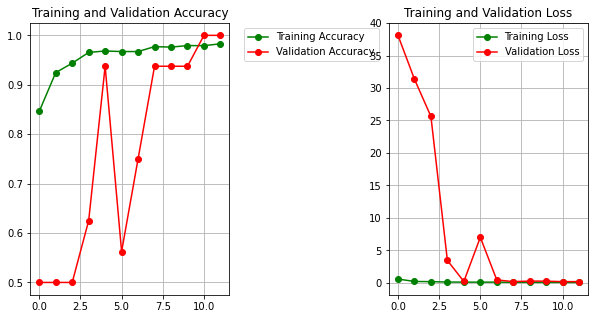

In [10]:
#Analysis of the model
#使用matplotlib.pyplot模块绘制训练集和验证集的准确率和损失值
import matplotlib.pyplot as plt
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1, 2)
ax[0].plot(epochs, history.history['accuracy'], 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, history.history['val_accuracy'], 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
ax[0].grid(True)

fig.subplots_adjust(wspace=0.8)

fig.set_size_inches(10, 5)
ax[1].plot(epochs, history.history['loss'], 'go-', label = 'Training Loss')
ax[1].plot(epochs, history.history['val_loss'], 'ro-', label = 'Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
ax[1].grid(True)



In [11]:
#Prediction
#使用predict()函数对测试集进行预测
y_pred = model.predict(x_test)
y_pred = [1 if y>=0.5 else 0 for y in y_pred]
y_pred = np.array(y_pred)
y_pred = y_pred.reshape(1, -1)[0]
y_pred[:10]

print(classification_report(y_test, y_pred,targer_names=['Normal(0)','Pneumonia(1)']))

#Confusion Matrix
#使用sklearn.metrics模块的confusion_matrix()函数创建混淆矩阵 -> 评估模型的性能

#from sklearn.metrics import confusion_matrix
con_m = confusion_matrix(y_test, y_pred)
print(con_m)

20/20 [==============================] - 7s 355ms/step
[[196  38]
 [ 22 368]]
